In [1]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray as rxr
import pystac_client
import planetary_computer
# import panel as pn
# import panel.widgets as pnw
import hvplot.xarray
# import holoviews as hv
import geoviews as gv
# from pystac.extensions.eo import EOExtension as eo
import datetime
from cartopy import crs
from dask.distributed import Client, LocalCluster
import odc.stac
import dask

gv.extension('bokeh')

In [2]:
cluster = LocalCluster()
client = Client(cluster)
client

/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44831 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44831/status,
Dashboard: http://127.0.0.1:44831/status,Workers: 8
Total threads: 64,Total memory: 187.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37195,Workers: 8
Dashboard: http://127.0.0.1:44831/status,Total threads: 64
Started: Just now,Total memory: 187.55 GiB
Comm: tcp://127.0.0.1:40721,Total threads: 8
Dashboard: http://127.0.0.1:44323/status,Memory: 23.44 GiB
Nanny: tcp://127.0.0.1:46835,


In [3]:
stac_root = 'https://planetarycomputer.microsoft.com/api/stac/v1'
catalog = pystac_client.Client.open(
    stac_root,
    modifier=planetary_computer.sign_inplace
)
print(f"{catalog.title} - {catalog.description}")

Microsoft Planetary Computer STAC API - Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


In [4]:
sentinel2_collections = [collection for collection in catalog.get_collections() if "sentinel-2" in collection.id]
sentinel2_collections

[<CollectionClient id=sentinel-2-l2a>]

parameters to filter the stac catalog by

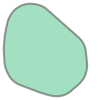

In [5]:
import geopandas as gpd
from pathlib import Path

# read the bounding box of the study area
val_pts = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'))

dumboor_pt = val_pts.loc[val_pts['tmsos_id']=='0505']
dumboor_poly = val_polys.loc[val_polys['tmsos_id']=='0505']

buffered_roi = dumboor_poly.geometry.iloc[0].convex_hull.buffer(0.05)
bbox = buffered_roi.bounds
buffered_roi

In [6]:
# bbox = [-105.283263,39.972809,-105.266569,39.987640] # NCAR, boulder, CO. bbox from http://bboxfinder.com/
date_range = "2019-01-01/2019-01-31"
collection = "sentinel-2-l2a"                        # full id of collection
cloud_thresh = 30

In [7]:
search = catalog.search(
    collections = sentinel2_collections,
    bbox = bbox,
    datetime = date_range,
    query={"eo:cloud_cover": {"lt": cloud_thresh}}
)
items = search.item_collection()
print(f"Found {len(items)} items in the {collection}")

Found 20 items in the sentinel-2-l2a


In [8]:
first_item = items.items[0]
all_bands = list(first_item.assets.keys())
print("Assets available:")
print(*all_bands, sep=', ')

Assets available:
AOT, B01, B02, B03, B04, B05, B06, B07, B08, B09, B11, B12, B8A, SCL, WVP, visual, preview, safe-manifest, granule-metadata, inspire-metadata, product-metadata, datastrip-metadata, tilejson, rendered_preview


In [9]:
dumboor_poly.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
# bands_of_interest = [b for b in all_bands if b.startswith('B')]
bands_of_interest = ['B04', 'B03', 'B02', 'B08']

da = odc.stac.stac_load(
    items,
    bands=bands_of_interest,
    bbox=bbox,
    chunks={'time': 1},  # <-- use Dask
).to_array(dim='band')

da = da.expand_dims('reservoir').assign_coords(reservoir=['0505'])
# mask values to buffered roi
da = da.rio.clip(dumboor_poly.geometry.to_crs(da.rio.crs).buffer(10000), crs=da.rio.crs)

da

<xarray.DataArray (reservoir: 1, band: 4, time: 10, y: 2336, x: 1948)> Size: 728MB
dask.array<where, shape=(1, 4, 10, 2336, 1948), dtype=float32, chunksize=(1, 1, 1, 2336, 1948), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 19kB 2.61e+06 2.61e+06 ... 2.587e+06 2.587e+06
  * x            (x) float64 16kB 3.732e+05 3.732e+05 ... 3.926e+05 3.926e+05
  * time         (time) datetime64[ns] 80B 2019-01-02T04:31:51.024000 ... 201...
  * band         (band) object 32B 'B04' 'B03' 'B02' 'B08'
  * reservoir    (reservoir) <U4 16B '0505'
    spatial_ref  int64 8B 0

In [11]:
# from https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Baseline-Change
def harmonize_to_old(data):  
    """
    Harmonize new Sentinel-2 data to the old baseline.

    Parameters
    ----------
    data: xarray.DataArray
        A DataArray with four dimensions: time, band, y, x

    Returns
    -------
    harmonized: xarray.DataArray
        A DataArray with all values harmonized to the old
        processing baseline.
    """
    cutoff = datetime.datetime(2022, 1, 25)
    offset = 1000
    bands = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]

    old = data.sel(time=slice(cutoff))

    to_process = list(set(bands) & set(data.band.data.tolist()))
    new = data.sel(time=slice(cutoff, None)).drop_sel(band=to_process)

    new_harmonized = data.sel(time=slice(cutoff, None), band=to_process).clip(offset)
    new_harmonized -= offset

    new = xr.concat([new, new_harmonized], "band").sel(band=data.band.data.tolist())
    return xr.concat([old, new], dim="time")

da = harmonize_to_old(da)
da

<xarray.DataArray (reservoir: 1, band: 4, time: 10, y: 2336, x: 1948)> Size: 728MB
dask.array<where, shape=(1, 4, 10, 2336, 1948), dtype=float32, chunksize=(1, 1, 1, 2336, 1948), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 19kB 2.61e+06 2.61e+06 ... 2.587e+06 2.587e+06
  * x            (x) float64 16kB 3.732e+05 3.732e+05 ... 3.926e+05 3.926e+05
  * time         (time) datetime64[ns] 80B 2019-01-02T04:31:51.024000 ... 201...
  * band         (band) object 32B 'B04' 'B03' 'B02' 'B08'
  * reservoir    (reservoir) <U4 16B '0505'
    spatial_ref  int64 8B 0

In [18]:
da = da / 1e4   # Scale data values from 0:10000 to 0:1.0

In [19]:
s2_dir = Path('../data/s2')
s2_dir.mkdir(exist_ok=True)

res_dir = s2_dir / '0505'
res_dir.mkdir(exist_ok=True)

ds = da.to_dataset(name='s2')

dates, dsses = zip(*ds.groupby("time.date"))
paths = [res_dir / f"{t}.nc" for t in dates]

tasks = xr.save_mfdataset(dsses, paths, compute=False)
dask.compute(tasks)

([None, None, None, None, None, None, None, None, None, None],)

In [24]:
def calc_ndwi(da):
    """
    Calculate the Normalized Difference Water Index (NDWI)
    """
    green = da.sel(band="B03")
    nir = da.sel(band="B08")
    return (green - nir) / (green + nir)

ndwi = calc_ndwi(da)
ndwi

<xarray.DataArray (reservoir: 1, time: 10, y: 2336, x: 1948)> Size: 182MB
dask.array<truediv, shape=(1, 10, 2336, 1948), dtype=float32, chunksize=(1, 1, 2336, 1948), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 19kB 2.61e+06 2.61e+06 ... 2.587e+06 2.587e+06
  * x            (x) float64 16kB 3.732e+05 3.732e+05 ... 3.926e+05 3.926e+05
  * time         (time) datetime64[ns] 80B 2019-01-02T04:31:51.024000 ... 201...
  * reservoir    (reservoir) <U4 16B '0505'
    spatial_ref  int64 8B 0

In [25]:
ndwi.isel(time=5).hvplot.image(
    x='x', y='y'
).opts(aspect='equal', clim=(-1, 0.3), cmap='RdYlBu')